In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym finta

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from finta import TA

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C
from stable_baselines.common.callbacks import CheckpointCallback, EvalCallback

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
df = pd.read_csv('gdrive/My Drive/stock/TSLA.csv')

In [5]:
df["Date"] = pd.to_datetime(df["Date"])

In [6]:
df.set_index('Date', inplace=True)

In [7]:
df = df.sort_values(by=["Date"])

In [8]:
df["Volume"] = df["Volume"].astype(float)

In [9]:
df['SMA'] = TA.SMA(df, 10)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [10]:
del df["Adj Close"]

In [11]:
df

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2010-06-30,5.158000,6.084000,4.660000,4.766000,85935500.0,0.000000,0.000000,0.000000e+00
2010-07-01,5.000000,5.184000,4.054000,4.392000,41094000.0,0.000000,0.000000,-4.109400e+07
2010-07-02,4.600000,4.620000,3.742000,3.840000,25699000.0,0.000000,0.000000,-6.679300e+07
2010-07-06,4.000000,4.000000,3.166000,3.222000,34334500.0,0.000000,0.000000,-1.011275e+08
2010-07-07,3.280000,3.326000,2.996000,3.160000,34608500.0,0.000000,0.000000,-1.357360e+08
...,...,...,...,...,...,...,...,...
2020-09-21,453.130005,455.679993,407.070007,449.390015,109476800.0,406.666000,59.430364,4.723109e+09
2020-09-22,429.600006,437.760010,417.600006,424.230011,79580800.0,416.068002,54.334777,4.643528e+09
2020-09-23,405.160004,412.149994,375.880005,380.359985,95074200.0,417.476001,46.799953,4.548454e+09


In [12]:
## Random Action

In [13]:
env = gym.make('stocks-v0', df=df, frame_bound=(50,150), window_size=5)

In [14]:
env.action_space

Discrete(2)

info {'total_reward': 1.806000000000001, 'total_profit': 0.9335662295926386, 'position': 1}


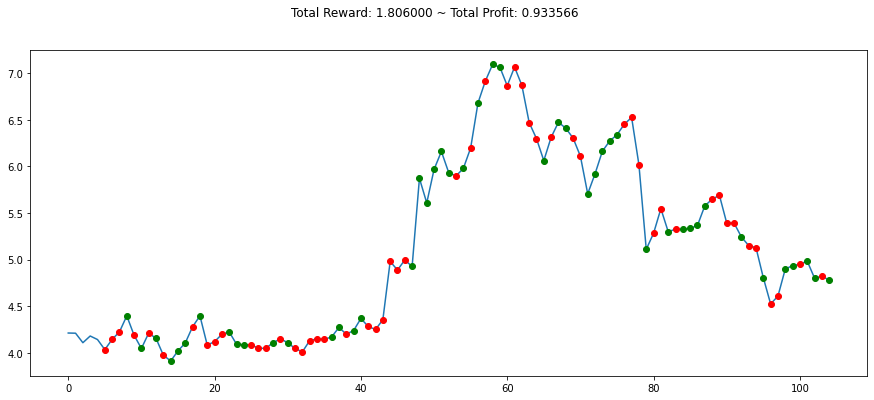

max_possible_profit: 4.585780658982301


In [15]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())

In [16]:
# First model

In [17]:
eval_callback = EvalCallback(env, best_model_save_path='gdrive/My Drive/stock/logs/',
                             log_path='gdrive/My Drive/stock/logs/', eval_freq=500,
                             deterministic=True, render=False)

checkpoint_callback = CheckpointCallback(save_freq=500, save_path='gdrive/My Drive/stock/logs/',
                                         name_prefix='rl_model')

In [18]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(50,150), window_size=5)
env = DummyVecEnv([env_maker])

In [19]:
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=100000, callback=eval_callback)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.0434   |
| fps                | 16       |
| nupdates           | 1        |
| policy_entropy     | 0.687    |
| total_timesteps    | 5        |
| value_loss         | 0.0362   |
---------------------------------
Eval num_timesteps=500, episode_reward=0.00 +/- 0.00
Episode length: 99.00 +/- 0.00
New best mean reward!
---------------------------------
| explained_variance | 0.0528   |
| fps                | 209      |
| nupdates           | 100      |
| policy_entropy     | 0.687    |
| total_timesteps    | 500      |
| value_loss         | 0.00834  |
---------------------------

info {'total_reward': 0.0, 'total_profit': 0.9466714285714286, 'position': 1}


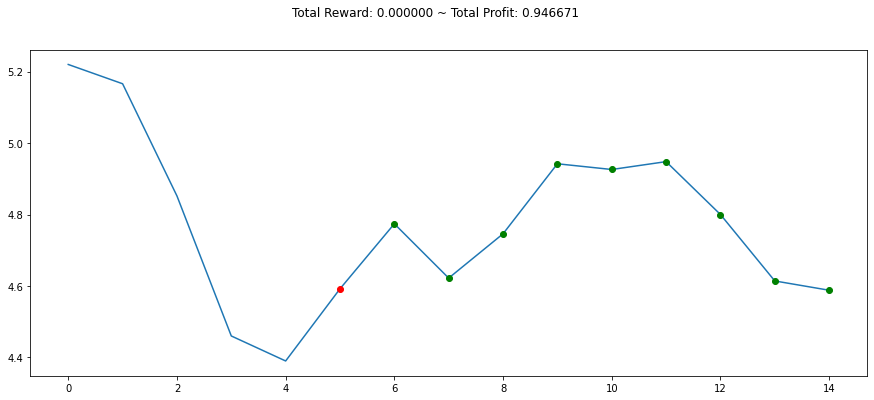

max_possible_profit: 1.1679546439012116


In [20]:
env = gym.make('stocks-v0', df=df, frame_bound=(290,300), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())

info {'total_reward': -2.8320000000000007, 'total_profit': 1.1212760097479872, 'position': 1}


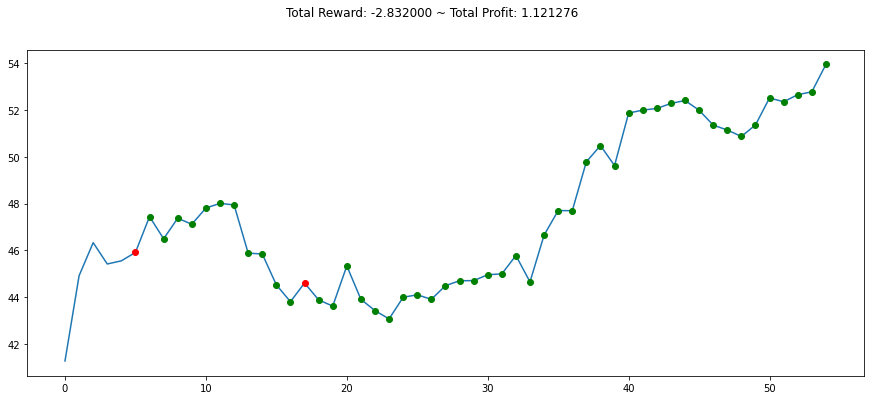

max_possible_profit: 1.5505197734503047


In [21]:
env = gym.make('stocks-v0', df=df, frame_bound=(1000,1050), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())

info {'total_reward': -7.640002999999993, 'total_profit': 0.6799516918644463, 'position': 1}


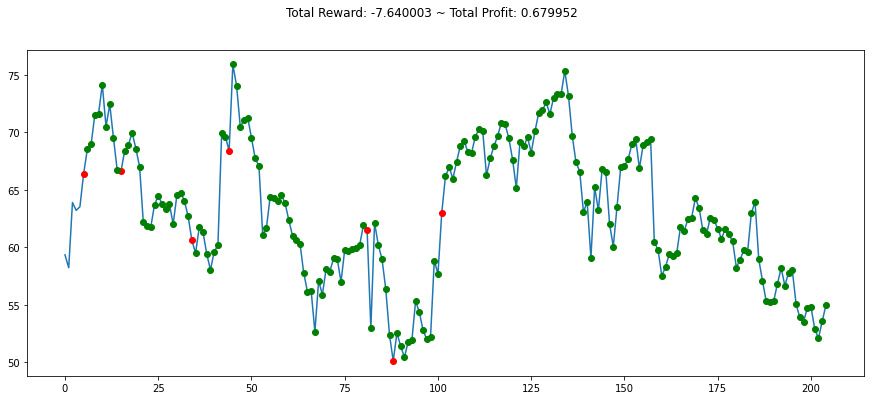

max_possible_profit: 13.578468531453384


In [22]:
env = gym.make('stocks-v0', df=df, frame_bound=(2000,2200), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())

info {'total_reward': -0.12399999999999967, 'total_profit': 0.8914770760309633, 'position': 1}


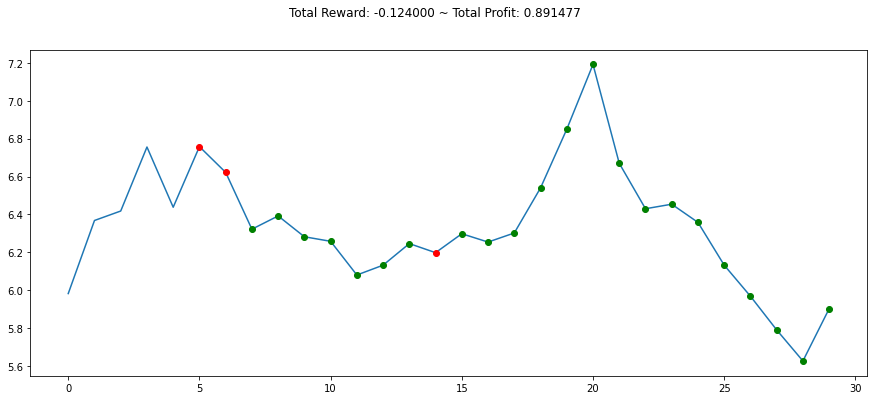

max_possible_profit: 1.3415542585551574


In [23]:
env = gym.make('stocks-v0', df=df, frame_bound=(500,525), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

print("max_possible_profit:", env.max_possible_profit())